# Supercompressible (3d)

L. F. Pereira (lfpereira@fe.up.pt)\
September 7, 2020

This notebook applies the data-driven framework to the supercompressible problem (see definition below). It comprises the following steps:
1. Design of experiments
2. Numerical simulations

The numerical models were developed in **Abaqus** and are based on simple Python scripts that can be obtained e.g. from .rpy files. `f3dasm` also contains its own Abaqus development modules, but for the sake of simplicity they will not be mentioned today.

## Problem definition

<img src="img/supercompressible.jpg" width=200>

### Inputs

The supercompressible metamaterial is parameterized by **7 geometric parameters** and **2 material parameters**. 

The **geometry** is defined by the top and bottom diameters, $D_1$ and $D_2$, the height $P$ and the cross-section parameters of the vertical longerons: the cross-sectional area $A$, moments of inertial $I_x$ and $I_y$, and torsional constant $J$. 

The **isotropic material** is defined by its elastic constants: Young's modulus $E$ and shear modulus $G$.

Due to the principle of superposition both the geometric and material parameters can be scaled by one of its dimensions/properties (here $D_1$ and $E$). Therefore, the variables that you will find in the dataset are:

\begin{equation*}
\frac{D_1-D_2}{D_1},\ \frac{P}{D_1},\ \frac{I_x}{D_1^4},\ \frac{I_y}{D_1^4},\ \frac{J}{D_1^4},\ \frac{A}{D_1^2}, \frac{G}{E}
\end{equation*}

This is a 7-dimensional problem and learning the response surface may require a significant amount of training points (remember the ``curse of dimensionality''!). Therefore, you will instead consider a simpler version of the problem in **3 dimensions**, through constraining the longerons' cross-section to be circular with diameter $d$, and choosing a particular material, leading to the following 3 features:

\begin{equation*}
\frac{d}{D_1},\ \frac{D_2-D_1}{D_1},\ \frac{P}{D_1}
\end{equation*}

### Outputs

For **each data point** (i.e. for each material design) we can use **nonlinear finite element analyses** to predict the complete buckling and post-buckling behavior. From the analyses, we can understand if a material **is coilable** and compute the **critical buckling stress** $\sigma_{crit}$ (defined as the critical buckling load divided by the area of the bottom ring of the metamaterial) and the **energy absorbed** $E_{abs}$.

### Sample data

In order to understand better which are the outputs from the numerical analyses, let's consider sample results data obtained with the following parameters:

\begin{equation*}
\frac{d}{D_1}=0.0040,\ \frac{D_2-D_1}{D_1}=0.00,\ \frac{P}{D_1}=0.2500
\end{equation*}

The other parameters are according to the values fixed below (`fixed_variables`).


In [1]:
# imports

# standard library
import os
import pickle

# third-party
from matplotlib import pyplot as plt

# local
from abaqus_modules.get_results import get_results_lin_buckle
from abaqus_modules.get_results import read_and_clean_results_riks

We start by importing the required data.

In [2]:
with open(os.path.join('sample_data', 'DoE_point0.pkl'), 'rb') as file:
    data_sim = pickle.load(file, encoding='latin1')

The first two output variables (coilability and $\sigma_{crit}$) result from a **linear buckling analyses**.

**Coilability** is simply an integer, which tells if the material is **coilable** or not. If the material is coilable, there's a further categorization to distinguish between materials that **yield** from those who not.

In [3]:
coilable, sigma_crit = get_results_lin_buckle(data_sim)

print('coilability: {}'.format(coilable))
print('sigma_crit: {:.6f}'.format(sigma_crit))

coilability: 1
sigma_crit: 0.000494


The energy absorbed $E_{abs}$ is computed from the output of a **Riks analysis** that follows the linear buckling analyses.

energy absorbed: 0.000285


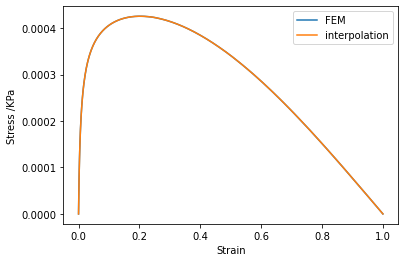

In [4]:
_, (strain, stress), (energy, (x, y)), _ = read_and_clean_results_riks(data_sim, get_energy=True)

# print info
print('energy absorbed: {:.6f}'.format(energy))

# plot
fig, ax = plt.subplots()
ax.plot(strain, stress, label='FEM')
ax.plot(x, y, label='interpolation')
ax.set_xlabel('Strain')
ax.set_ylabel('Stress /KPa')
ax.legend();

## `f3dasm`

`f3dasm` is the in-house **Python library** to manage the application of the data-driven framework. The code is still under development, but an initial version can already be installed through `pip` (it can be installed as any other Python package, e.g. `pip install f3dasm`). The code is open-source and can be found in github temporarily on https://github.com/lpereira95/f3dasm; it will be soon moved to https://github.com/bessagroup/F3DASM).

Before moving on, let's import the required Python libraries.

In [5]:
# imports

# standard library
import os
import pickle
from collections import OrderedDict

# third-party
import numpy as np
from matplotlib import pyplot as plt
from f3dasm.run.utils import create_main_file
from f3dasm.run.utils import create_sim_info
from f3dasm.run.abaqus import run_sims
from f3dasm.run.stats import analyze_times
from f3dasm.design_of_experiments import create_doe

# local library
from abaqus_modules.get_results import get_results

Now we define the example name and the number of points.

In [6]:
example_name = 'example_0'

n_pts = 10  # number of points

In [7]:
import shutil

if os.path.exists(example_name):
    shutil.rmtree(example_name)

A quick verification of the chosen name will be performed to avoid overriding existing folders.

In [8]:
if os.path.exists(example_name):
    raise Exception('Name already exists')

### Variable definition and  design of experiments

Let's define the **variables of the problem**, both the variables that are defined by the design of experiments scheme and the fixed variables (i.e. the variables that are common for all simulations).

**Note**: the use of an ```OrderedDict``` is not mandatory, but forces variable order in the ```Pandas``` frame.

In [9]:
doe_variables = OrderedDict({'ratio_d': [0.004, 0.073],
                             'ratio_pitch': [.25, 1.5],
                             'ratio_top_diameter': [0., 0.8]})
fixed_variables = {'n_longerons': 3,
                   'bottom_diameter': 100.,
                   'young_modulus': 3500.,
                   'shear_modulus': 1287.,}

Now, using a proper design of experiments scheme, we can create the design of experiments. Here, we simply use Sobol sequence implementation from ```SALib``` library. `create_doe` is a simple interface between `f3dasm` and `SALib`.

The design of experiments is stored in a ```pandas.DataFrame```. This is a convenient way for the subsequent application of Machine Learning.

In [10]:
points = create_doe(n_pts, doe_variables, sample_strat='sobol')

The generated DoE for the first `n` points is the following:

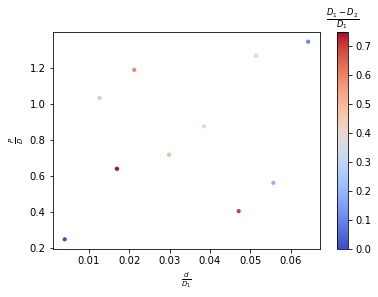

In [11]:
n = 10
s = 10

plt.figure()
plt.scatter(points.iloc[:n, 0], points.iloc[:n, 1], s=s, c=points.iloc[:n, 2],
          cmap=plt.cm.coolwarm)
plt.xlabel('$\\frac{d}{D_1}$')
plt.ylabel('$\\frac{P}{D}$')
clb = plt.colorbar()
clb.ax.set_title('$\\frac{D_1 - D_2}{D_1}$');

The supercompressible problem is *special*, in the way there's an additional variable that is not fixed nor controlled by the design of experiments scheme: **imperfections**. For `f3dasm`, these type of variables are considered `additional_variables` are are provided through a dictionary.

In [12]:
seed = 1
deg2rad = np.pi / 180
m = 4. * deg2rad  # mean
s = 1.2 * deg2rad  # std
sigma = np.sqrt(np.log(s**2 / m**2 + 1))
mu = np.log((m**2) / np.sqrt(s**2 + m**2))
imperfection_dist = {'mean': mu, 'sigma': sigma}
imperfections = np.random.lognormal(size=n_pts, **imperfection_dist)

additional_variables = {'imperfection': imperfections}

### Simulations metadata

Now, we have to provide numerical simulations metadata, i.e. information that about the location of the required functions to run and post-process the numerical models, additional arguments for the models, etc.

This step is quite straightforward.

For each simulation, we have to provide a name (`name`), the location of the function used to create the numerical model (`abstract_model`), information about the job that contains at least the job name (`job_info`) and, optionally, the location of the post processing function (`post_processing_fnc`).

Then, we just have to order the simulations (`sim_info`).

In [13]:
sim_info_buckle = create_sim_info(
    name='SUPERCOMPRESSIBLE_LIN_BUCKLE',
    abstract_model='abaqus_modules.supercompressible_fnc.lin_buckle',
    job_info={'name': 'Simul_supercompressible_lin_buckle'},
    post_processing_fnc='abaqus_modules.supercompressible_fnc.post_process_lin_buckle')

sim_info_riks = create_sim_info(
    name='SUPERCOMPRESSIBLE_RIKS',
    abstract_model='abaqus_modules.supercompressible_fnc.riks',
    job_info={'name': 'Simul_supercompressible_riks'},
    post_processing_fnc='abaqus_modules.supercompressible_fnc.post_process_riks')

sim_info = [sim_info_buckle, sim_info_riks]

### Main file creation

Finally, we gather all the information created previously and create the main file, which is a file that contains everything that is necessary to apply the data-driven framework.

Before, we can also store extra data (e.g. metadata of the problem).

In [14]:
additional_info = {'imperfection_dist': imperfection_dist,
                   'seed': seed}

In [15]:
create_main_file(example_name, doe_variables, points, sim_info,
                 fixed_variables=fixed_variables,
                 additional_variables=additional_variables,
                 additional_info=additional_info,)

### Run and post-process simulations

First, let's open the created file and see what it contains.

In [16]:
with open(os.path.join(example_name, 'DoE.pkl'), 'rb') as file:
    data = pickle.load(file)
    
print(data.keys())

dict_keys(['doe_variables', 'points', 'sim_info', 'run_info', 'version', 'fixed_variables', 'additional_variables', 'transform_inputs', 'additional_info'])


For the running step, the field `run_info` is of great importance, because it gives information about the simulations that are still missing or were already run (both successfully or with errors).

In [17]:
print(data['run_info'])

{'missing_sims': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 'running_sims': set(), 'error_sims': set(), 'successful_sims': set()}


We run the simulations through `run_sims`. We can control the simulations we want to run or choose to run the first `n_sims`.

We can also use parallel computating to run several simulations simultaneously (only allowed if each simulation uses only one cpu). In that case, a `jupyter notebook` may not be the most appropriate tool because all the code has necessarily to be within the condition `if __name__ == '__main__'`. e.g.:
```python
from f3dasm.abaqus.run.utils import run_sims

if __name__ == '__main__':
    # (...)
    
    run_sims(example_name)
```

If we provide a post-processing function (that simply accesses the simulation data and post-process it to be ameanable for the Machine Learning step), then the running step will finish only after updating the DoE with the quantities of interest.

All the raw data is concatenated in a file and we can control if we keep the original folders or simply delete them.

In [18]:
run_sims(example_name, points=[0], abaqus_path='abaqus',
         keep_odb=True, pp_fnc=get_results,
         raw_data_filename='raw_data.pkl', delete=False)

### After run

As we can see next, the DoE was updated with the output variables and some simulations are now considered `successful_sims`.

In [19]:
with open(os.path.join(example_name, 'DoE.pkl'), 'rb') as file:
    data = pickle.load(file)
    
print(data['run_info'])

{'missing_sims': {1, 2, 3, 4, 5, 6, 7, 8, 9}, 'running_sims': set(), 'error_sims': set(), 'successful_sims': {0}}


In [20]:
print(data['points'])

    ratio_d  ratio_pitch  ratio_top_diameter coilable   sigma_crit  \
0  0.004000     0.250000                0.00        1  0.000494204   
1  0.038500     0.875000                0.40     None         None   
2  0.055750     0.562500                0.20     None         None   
3  0.021250     1.187500                0.60     None         None   
4  0.029875     0.718750                0.50     None         None   
5  0.064375     1.343750                0.10     None         None   
6  0.047125     0.406250                0.70     None         None   
7  0.012625     1.031250                0.30     None         None   
8  0.016937     0.640625                0.75     None         None   
9  0.051437     1.265625                0.35     None         None   

        energy  
0  0.000291292  
1         None  
2         None  
3         None  
4         None  
5         None  
6         None  
7         None  
8         None  
9         None  


With `f3dasm` we can also perform a statistic analysis of the running times (that may be useful to identify weak points in the numerical simulation).

Missing simulations (total): 9/10 (90.0%)
With errors: 0/1 (0.0%)
Successful: 1/1 (100.0%)


Time-related information:
Total time [s]: 81.24
Total time for each simulation (mean [s] and std [s]): 81.24 and nan
Post-processing time [s]: 8.33 (10.26%)
Post-processing time for each simulation (mean [s] and std [s]): 8.33 and nan
Running time [s]: 72.85 (89.67%)
Running time for each simulation (mean [s] and std [s]): 72.85 and nan
Waiting time [s]: 0.00 (0.00%)
Waiting time for each simulation (mean [s] and std [s]): 0.00 and nan


C:\Users\filip\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


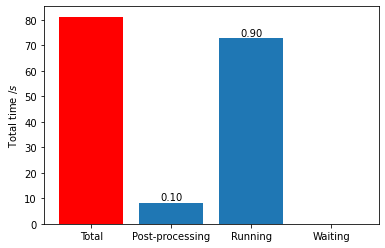

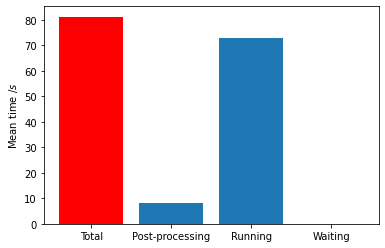

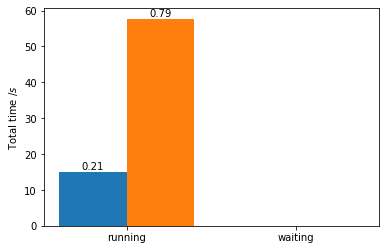

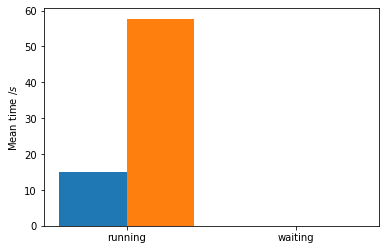

In [21]:
analyze_times(example_name, raw_data_filename='raw_data.pkl');